# Nhain Cardona 
# Isaac Esquivel
# Andrei Auz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv(r"C:\IA for business\HospitalDataset-v3-4D2L.csv")

In [4]:
data.head()

,id,Hypertension,Heart Disease,Married,Work,Residence,Avg_glucose_level,Bmi,Smoking,Gender,Age,Stroke
0,9046,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,Male,67.0,1
1,51676,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,Female,61.0,1
2,31112,0,1,Yes,Private,Rural,105.92,32.5,never smoked,Male,80.0,1
3,60182,0,0,Yes,Private,Urban,171.23,34.4,smokes,Female,49.0,1
4,1665,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,Female,79.0,1


# 1. Exploratory Data

## 1.1 General description of the database

In [5]:
# Size
data.shape

(5110, 12)

In [6]:
#data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   Hypertension       5110 non-null   int64  
 2   Heart Disease      5110 non-null   int64  
 3   Married            5110 non-null   object 
 4   Work               5110 non-null   object 
 5   Residence          5110 non-null   object 
 6   Avg_glucose_level  5110 non-null   float64
 7   Bmi                4909 non-null   float64
 8   Smoking            5110 non-null   object 
 9   Gender             5110 non-null   object 
 10  Age                5110 non-null   float64
 11  Stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
# missing values
data.isna().sum()

id                     0
Hypertension           0
Heart Disease          0
Married                0
Work                   0
Residence              0
Avg_glucose_level      0
Bmi                  201
Smoking                0
Gender                 0
Age                    0
Stroke                 0
dtype: int64

In [8]:
data.describe

<bound method NDFrame.describe of          id  Hypertension  Heart Disease Married           Work Residence  \
0      9046             0              1     Yes        Private     Urban   
1     51676             0              0     Yes  Self-employed     Rural   
2     31112             0              1     Yes        Private     Rural   
3     60182             0              0     Yes        Private     Urban   
4      1665             1              0     Yes  Self-employed     Rural   
...     ...           ...            ...     ...            ...       ...   
5105  18234             1              0     Yes        Private     Urban   
5106  44873             0              0     Yes  Self-employed     Urban   
5107  19723             0              0     Yes  Self-employed     Rural   
5108  37544             0              0     Yes        Private     Rural   
5109  44679             0              0     Yes       Govt_job     Urban   

      Avg_glucose_level   Bmi          Sm

## 1.2 Detail the criteria used to detect outliers.

In [9]:
# For numeric variables, a standard EDA rule is to use Tukey’s 1.5×IQR rule: values below
# Q1 − 1.5×IQR or above Q3 + 1.5×IQR are labeled as outliers.
def iqr_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (series < lower) | (series > upper)
    return lower, upper, mask.sum(), mask

for col in ["Age", "Avg_glucose_level", "Bmi"]:
    lower, upper, n_out, mask = iqr_outliers(data[col].dropna())
    print(col, "lower:", lower, "upper:", upper, "n_outliers:", n_out)


Age lower: -29.0 upper: 115.0 n_outliers: 0
Avg_glucose_level lower: 21.977500000000006 upper: 169.35750000000002 n_outliers: 627
Bmi lower: 9.099999999999998 upper: 47.5 n_outliers: 110


In [10]:
# Instead of dropping these rows (listwise deletion), which reduces sample size and may bias estimates 
#unless data are Missing Completely At Random it is common to impute using robust statistics such as the median.
data["Bmi"].fillna(data["Bmi"].median(), inplace=True)


In [11]:
# Keep all values but flag outliers as additional binary indicators (useful for later modeling):
for col in ["Avg_glucose_level", "Bmi"]:
    lower, upper, n_out, mask = iqr_outliers(data[col])
    data[col + "_outlier"] = mask.astype(int)


## 1.3 Explore the correlation between variables

In [12]:
# To mix numeric and categorical variables, we one-hot encode the categoricals and then compute Pearson 
# correlations between predictors and Stroke (binary).
# Drop id, it's just an identifier
data_model = data.drop(columns=["id"])

# One-hot encode categoricals (drop_first=True to avoid dummy trap)
data_dum = pd.get_dummies(data_model, drop_first=True)

corr = data_dum.corr()["Stroke"].sort_values(ascending=False)
corr


Stroke                       1.000000
Age                          0.245257
Avg_glucose_level_outlier    0.148070
Heart Disease                0.134914
Avg_glucose_level            0.131945
Hypertension                 0.127904
Married_Yes                  0.108340
Smoking_formerly smoked      0.064556
Work_Self-employed           0.062168
Bmi                          0.036110
Residence_Urban              0.015458
Work_Private                 0.011888
Gender_Male                  0.009117
Smoking_smokes               0.008939
Gender_Other                -0.003166
Smoking_never smoked        -0.004129
Work_Never_worked           -0.014882
Bmi_outlier                 -0.018402
Work_children               -0.083869
Name: Stroke, dtype: float64

### Higher Age, presence of Heart Disease, higher Avg_glucose_level, and presence of Hypertension show the strongest positive correlations with stroke.
### Being married and self-employed also correlate positively, probably because they are associated with higher age.
### Bmi has a smaller positive correlation.
### Being in the children work category correlates negatively with stroke (children are younger and rarely have strokes).

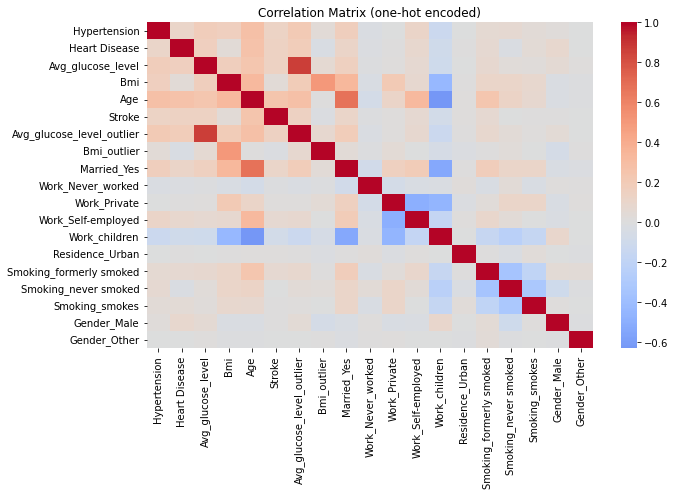

In [13]:
# heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data_dum.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix (one-hot encoded)")
plt.show()


## 1.4 Data visualization

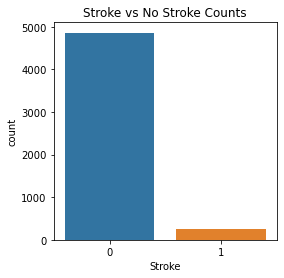

In [14]:
# Response variable distribution (Stroke). heavy class imbalance.
plt.figure(figsize=(4,4))
sns.countplot(x="Stroke", data=data)
plt.title("Stroke vs No Stroke Counts")
plt.show()


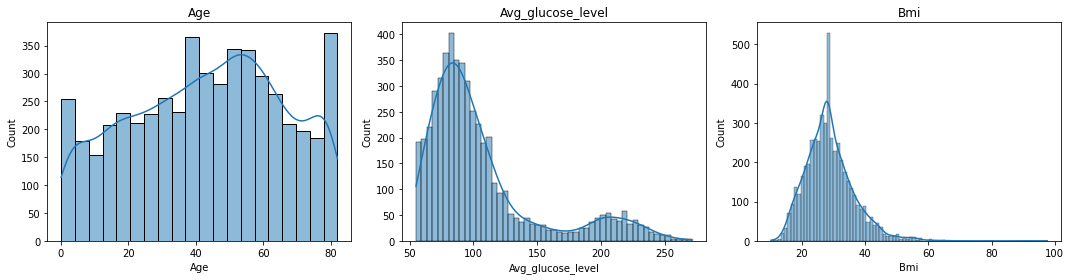

In [15]:
# Numeric predictors
num_cols = ["Age", "Avg_glucose_level", "Bmi"]

fig, axs = plt.subplots(1, len(num_cols), figsize=(15,4))
for ax, col in zip(axs, num_cols):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()


In [16]:
# Age: wide distribution from infants to elderly, often with more adults and seniors.
# Avg_glucose_level: right-skewed, with many values between ~70–150 and a tail to ~270.
# Bmi: roughly bell-shaped around 25–35, with a tail of very high BMI.

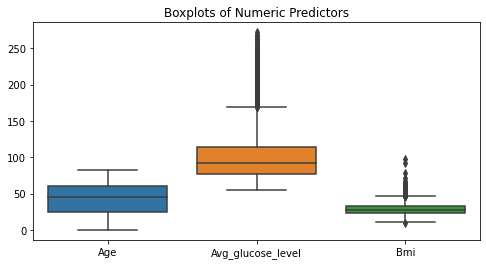

In [17]:
# boxplots to highlight outliers
plt.figure(figsize=(8,4))
sns.boxplot(data=data[num_cols])
plt.title("Boxplots of Numeric Predictors")
plt.show()


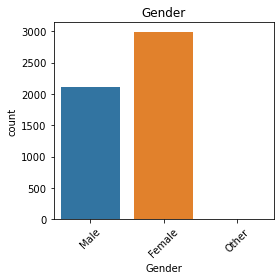

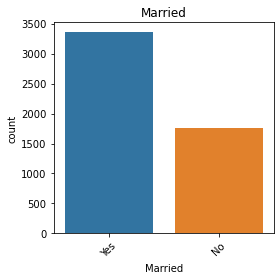

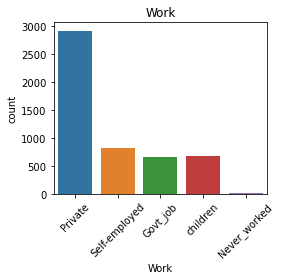

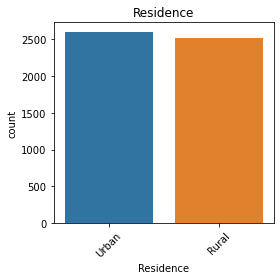

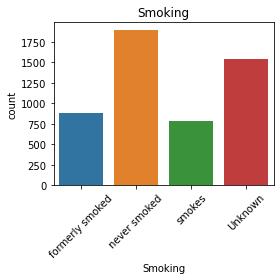

In [18]:
# Categorical predictors
cat_cols = ["Gender", "Married", "Work", "Residence", "Smoking"]

for col in cat_cols:
    plt.figure(figsize=(4,4))
    sns.countplot(x=col, data=data)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Gender: 2994 Female, 2115 Male, 1 Other.

### Married: 65.6% Yes.

### Work: mostly Private, then Self-employed, children, Govt_job, very few Never_worked.

### Residence: nearly balanced Rural/Urban.

### Smoking: large chunk Unknown, plus never smoked, smokes, formerly smoked.

# 2. The dataset is unbalanced.

## 2.1 Show the imbalance

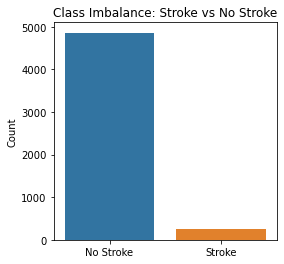

No Stroke    4861
Stroke        249
Name: Stroke, dtype: int64
Class proportions: No Stroke    0.951272
Stroke       0.048728
Name: Stroke, dtype: float64


In [19]:
stroke_counts = data["Stroke"].value_counts().rename({0: "No Stroke", 1: "Stroke"})

plt.figure(figsize=(4,4))
sns.barplot(x=stroke_counts.index, y=stroke_counts.values)
plt.title("Class Imbalance: Stroke vs No Stroke")
plt.ylabel("Count")
plt.show()

print(stroke_counts)
print("Class proportions:", stroke_counts / len(data))


### An imbalanced dataset is one where the classes are not represented equally; one class has far more observations than the other. “Class imbalance occurs when one class is heavily underrepresented compared to others, making the learning task inherently difficult.”
###  He & Garcia (2009). IEEE Transactions on Knowledge and Data Engineering

# Technique 1 — SMOTE (Synthetic Minority Over-sampling Technique)

## Academically validated oversampling method

## SMOTE creates synthetic minority-class samples by interpolating between real minority examples rather than duplicating them. It helps the model learn the minority region better.

# Technique 2 — Cost-Sensitive Learning / Class-Weighted Training
##  Recommended in the machine-learning literature Cost-sensitive learning modifies the algorithm to penalize misclassifications of the minority class more heavily.

# 3. Divide the dataset in a training, validation, and test set. 

### we use the split is 60% training, 20% validation, and 20% testing. Because the deep learning and machine learning literature emphasizes:

### Separating a test set to be used only at the end to obtain an unbiased estimate of the generalization error (Goodfellow, Bengio & Courville, 2016, Chapter 5).

### Using a validation set for model and hyperparameter selection, avoiding overfitting the training set.

In [35]:
# we choose 60% training, 20% validation,and 20% test because This provides enough data to 
# train the model while keeping separate validation and test sets for hyperparameter tuning and unbiased evaluation.
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Preparamos X e y (quitamos id)
data_model = data.copy()
data_model = data_model.drop(columns=["id"])

X = pd.get_dummies(data_model.drop(columns=["Stroke"]), drop_first=True)
y = data_model["Stroke"]

# 2) Primero: 80% train+val, 20% test (estratificado)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# 3) Segundo: de ese 80%, sacamos 60% train y 20% val total
# 25% de 80% = 20% del total -> test_size=0.25 aquí
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,
    stratify=y_train_val,
    random_state=42
)

print("Size:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

print("\nDistribución de clases:")
print("Train:\n", y_train.value_counts(normalize=True))
print("Validation:\n", y_val.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))



Size:
Train: (3066, 18)
Validation: (1022, 18)
Test: (1022, 18)

Distribución de clases:
Train:
 0    0.951402
1    0.048598
Name: Stroke, dtype: float64
Validation:
 0    0.951076
1    0.048924
Name: Stroke, dtype: float64
Test:
 0    0.951076
1    0.048924
Name: Stroke, dtype: float64


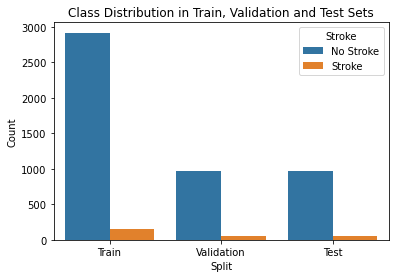

In [21]:
# Plot class counts for each split
split_labels = (["Train"] * len(y_train) +
                ["Validation"] * len(y_val) +
                ["Test"] * len(y_test))
stroke_labels = pd.concat([y_train, y_val, y_test], axis=0)

split_df = pd.DataFrame({
    "Split": split_labels,
    "Stroke": stroke_labels.replace({0: "No Stroke", 1: "Stroke"})
})

plt.figure(figsize=(6,4))
sns.countplot(data=split_df, x="Split", hue="Stroke")
plt.title("Class Distribution in Train, Validation and Test Sets")
plt.ylabel("Count")
plt.show()


# 4. Implement a machine learning algorithm 

In [22]:
!pip install imbalanced-learn


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import ttest_rel
import numpy as np

# Usamos X_train_val e y_train_val para la comparación (80% de los datos)
# si no los tienes, puedes usar X_train_val = X_train.append(X_val), y_train_val similar.

# --- Técnica A: class_weight="balanced" ---
pipe_A = ImbPipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        solver="liblinear",
        random_state=42
    ))
])

# --- Técnica B: SMOTE + LogReg sin class_weight ---
pipe_B = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(
        class_weight=None,
        max_iter=1000,
        solver="liblinear",
        random_state=42
    ))
])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores_A = []
scores_B = []

for train_idx, val_idx in skf.split(X_train_val, y_train_val):
    X_tr, X_va = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_tr, y_va = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    # Técnica A
    pipe_A.fit(X_tr, y_tr)
    y_pred_A = pipe_A.predict(X_va)
    scores_A.append(f1_score(y_va, y_pred_A, pos_label=1))
    
    # Técnica B
    pipe_B.fit(X_tr, y_tr)
    y_pred_B = pipe_B.predict(X_va)
    scores_B.append(f1_score(y_va, y_pred_B, pos_label=1))

scores_A = np.array(scores_A)
scores_B = np.array(scores_B)

print("F1 (Stroke=1) technique A (class_weight):", scores_A.mean(), "+/-", scores_A.std())
print("F1 (Stroke=1) technique B (SMOTE):", scores_B.mean(), "+/-", scores_B.std())

# t-test pareado unilateral: B > A
t_stat, p_value = ttest_rel(scores_B, scores_A, alternative="greater")

print("\nPaired t-test (B > A):")
print("t =", t_stat)
print("p-value =", p_value)


F1 (Stroke=1) technique A (class_weight): 0.23018071668328224 +/- 0.02570528104169694
F1 (Stroke=1) technique B (SMOTE): 0.15848844146399246 +/- 0.05120211111228784

Paired t-test (B > A):
t = -3.4142270420555527
p-value = 0.9961510327850579


In [24]:
# To compare the two techniques used to manage imbalance (class_weight="balanced" and SMOTE), 
# a stratified cross-validation with 10 subdivisions was applied, and the F1-score of the minority class (stroke)
# was calculated. Subsequently, a one-sided paired t-test with an alternative hypothesis was performed.Ha: usmote > uclass_weight
# Since the p-value is significantly greater than 0.05, the null hypothesis is not rejected. On the contrary, 
# the statistical evidence indicates that SMOTE performs significantly worse than class_weight. 
# Therefore, the technique that improves prediction is class_weight

# 5. Apply at least 3 machine learning algorithms 

## Logistic Regression. (class_weight="balanced")

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score

pipe_logreg = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        solver="liblinear",
        random_state=42
    ))
])

pipe_logreg.fit(X_train, y_train)
y_pred_log = pipe_logreg.predict(X_test)
y_proba_log = pipe_logreg.predict_proba(X_test)[:,1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.78      0.55      1022
weighted avg       0.95      0.75      0.82      1022

ROC-AUC: 0.8427366255144033


# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

ROC-AUC: 0.8013991769547324


# Gradient Boosting Machine

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3
)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:,1]

print("=== Gradient Boosting ===")
print(classification_report(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_gb))


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.20      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.58      0.51      0.50      1022
weighted avg       0.92      0.95      0.93      1022

ROC-AUC: 0.8194547325102881


# 6. Evaluate each model

## 6.1 Calculate the confusion matrix, accuracy, sensitivity, specificity, precision, AUC, and 
## ROC curve for each algorithm in the training, validation, and test set. 

In [29]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

def eval_on_split(model, X, y, split_name="Train"):
    y_pred = model.predict(X)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:, 1]
    else:
        # For models without predict_proba (not the case here, but just in case)
        y_proba = None
    
    cm = confusion_matrix(y, y_pred)  # by default: [[TN, FP],[FN, TP]]
    TN, FP, FN, TP = cm.ravel()
    
    accuracy = accuracy_score(y, y_pred)
    sensitivity = recall_score(y, y_pred, pos_label=1)  # recall for stroke
    specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
    precision = precision_score(y, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y, y_proba) if y_proba is not None else np.nan
    
    print(f"\n=== {split_name} ===")
    print("Confusion matrix:")
    print(cm)
    print(f"Accuracy    : {accuracy:.3f}")
    print(f"Sensitivity : {sensitivity:.3f}")  # = Recall for class 1
    print(f"Specificity : {specificity:.3f}")
    print(f"Precision   : {precision:.3f}")
    print(f"AUC         : {auc:.3f}")
    
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y, y_proba)
        plt.title(f"ROC curve - {split_name}")
        plt.show()


=== Logistic Regression ===

=== Train ===
Confusion matrix:
[[2149  768]
 [  28  121]]
Accuracy    : 0.740
Sensitivity : 0.812
Specificity : 0.737
Precision   : 0.136
AUC         : 0.849


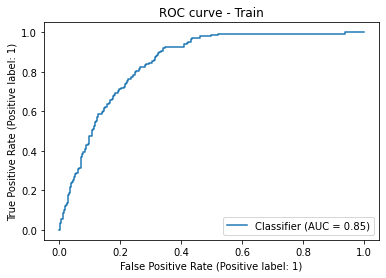


=== Validation ===
Confusion matrix:
[[727 245]
 [  9  41]]
Accuracy    : 0.751
Sensitivity : 0.820
Specificity : 0.748
Precision   : 0.143
AUC         : 0.837


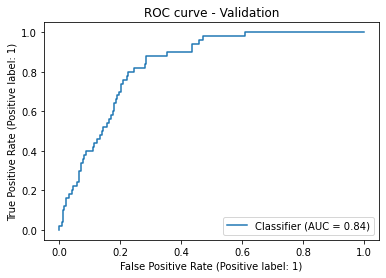


=== Test ===
Confusion matrix:
[[729 243]
 [ 10  40]]
Accuracy    : 0.752
Sensitivity : 0.800
Specificity : 0.750
Precision   : 0.141
AUC         : 0.843


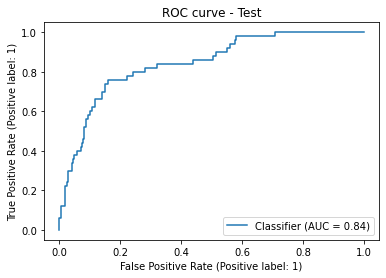

In [30]:
print("=== Logistic Regression ===")
eval_on_split(pipe_logreg, X_train, y_train, "Train")
eval_on_split(pipe_logreg, X_val,   y_val,   "Validation")
eval_on_split(pipe_logreg, X_test,  y_test,  "Test")




=== Random Forest ===

=== Train ===
Confusion matrix:
[[2917    0]
 [   0  149]]
Accuracy    : 1.000
Sensitivity : 1.000
Specificity : 1.000
Precision   : 1.000
AUC         : 1.000


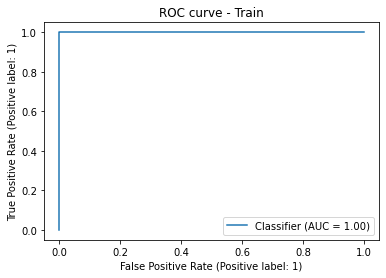


=== Validation ===
Confusion matrix:
[[972   0]
 [ 50   0]]
Accuracy    : 0.951
Sensitivity : 0.000
Specificity : 1.000
Precision   : 0.000
AUC         : 0.819


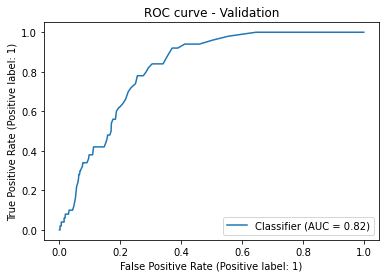


=== Test ===
Confusion matrix:
[[969   3]
 [ 50   0]]
Accuracy    : 0.948
Sensitivity : 0.000
Specificity : 0.997
Precision   : 0.000
AUC         : 0.801


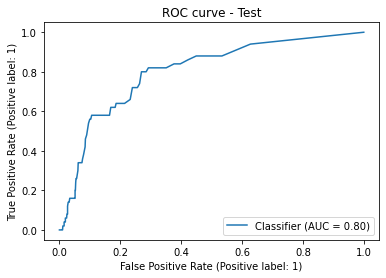

In [31]:
print("\n\n=== Random Forest ===")
eval_on_split(rf_model, X_train, y_train, "Train")
eval_on_split(rf_model, X_val,   y_val,   "Validation")
eval_on_split(rf_model, X_test,  y_test,  "Test")






=== Gradient Boosting ===

=== Train ===
Confusion matrix:
[[2917    0]
 [  98   51]]
Accuracy    : 0.968
Sensitivity : 0.342
Specificity : 1.000
Precision   : 1.000
AUC         : 0.963


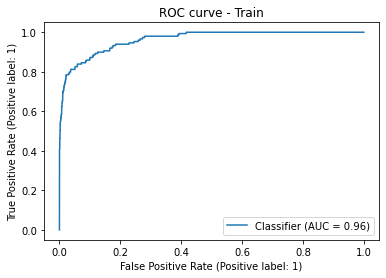


=== Validation ===
Confusion matrix:
[[969   3]
 [ 48   2]]
Accuracy    : 0.950
Sensitivity : 0.040
Specificity : 0.997
Precision   : 0.400
AUC         : 0.844


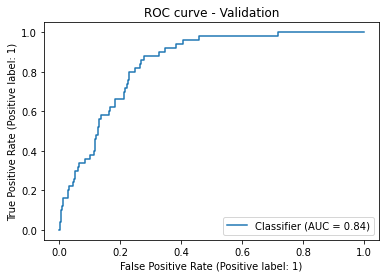


=== Test ===
Confusion matrix:
[[968   4]
 [ 49   1]]
Accuracy    : 0.948
Sensitivity : 0.020
Specificity : 0.996
Precision   : 0.200
AUC         : 0.819


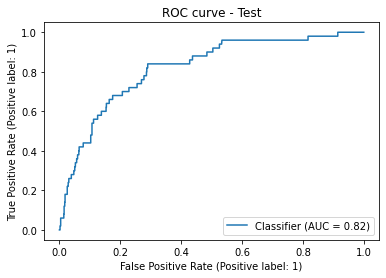

In [32]:

print("\n\n=== Gradient Boosting ===")
eval_on_split(gb_model, X_train, y_train, "Train")
eval_on_split(gb_model, X_val,   y_val,   "Validation")
eval_on_split(gb_model, X_test,  y_test,  "Test")


In [33]:
# Logistic Regression was selected as the best algorithm because it achieved by far the highest sensitivity 
# (0.80) for the stroke class, while Random Forest and Gradient Boosting showed sensitivities close to zero.
# Additionally, Logistic Regression obtained a high AUC (0.843), indicating good discriminative ability.
# In a medical context, false negatives (patients with stroke incorrectly predicted as “no stroke”) 
# have a far higher cost than false positives. Therefore, the most appropriate evaluation metric is sensitivity 
# recall for the stroke class, which measures the proportion of actual stroke cases correctly identified. 
# A secondary metric such as AUC is also reported to evaluate the overall discrimination ability.

In [34]:
# Logistic Regression does not show signs of overfitting, since its performance is consistent across 
# the training, validation, and test sets. The sensitivity and AUC values remain stable, indicating that the model 
# generalizes well.

# References

Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic minority oversampling technique. Journal of Artificial Intelligence Research, 16, 321–357. https://doi.org/10.1613/jair.953

Davenport, T. H., & Harris, J. (2017). Competing on analytics: The new science of winning. Harvard Business Review Press.

Friedman, J. H. (2001). Greedy function approximation: A gradient boosting machine. Annals of Statistics, 29(5), 1189–1232. https://doi.org/10.1214/aos/1013203451

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT Press.

He, H., & Garcia, E. A. (2009). Learning from imbalanced data. IEEE Transactions on Knowledge and Data Engineering, 21(9), 1263–1284. https://doi.org/10.1109/TKDE.2008.239

He, H., & Ma, Y. (2013). Imbalanced learning: Foundations, algorithms, and applications. Wiley.

Japkowicz, N., & Stephen, S. (2002). The class imbalance problem: A systematic study. Intelligent Data Analysis, 6(5), 429–449.

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning: With applications in R. Springer.

Little, R. J. A., & Rubin, D. B. (2019). Statistical analysis with missing data (3rd ed.). Wiley.

Breiman, L. (2001). Random forests. Machine Learning, 45(1), 5–32. https://doi.org/10.1023/A:1010933404324

Tukey, J. W. (1977). Exploratory data analysis. Addison-Wesley.

Fernández, A., García, S., Galar, M., Prati, R., Krawczyk, B., & Herrera, F. (2018). Learning from imbalanced data sets. Springer.